# Stage 11 Homework — Evaluation & Risk Communication
In the lecture, we learned **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.
Now, you will adapt those methods to your dataset and produce assumption-aware results.

In [28]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data (provided or synthetic fallback)

In [29]:
from pathlib import Path
import pandas as pd
import numpy as np

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    try:
        df = pd.read_csv(csv_path, parse_dates=['date'])
    except ValueError as e:
        print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
        regenerate = True
    else:
        regenerate = False
else:
    regenerate = True

if regenerate:
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    x = np.linspace(0, 9, n) + np.random.normal(0, 0.7, n)
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    df.to_csv(csv_path, index=False)

df.head()


,date,segment,x_feature,y_target
0,2022-06-01,B,0.547868,2.107524
1,2022-06-02,A,0.974480,2.209111
2,2022-06-03,A,-0.012991,0.867315
3,2022-06-04,B,-1.012503,-1.741932
4,2022-06-05,A,0.642399,1.615007


## Helper Functions (complete or modify as needed)

In [48]:
# /src/evaluation.py
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mae(y_true, y_pred):
    return float(mean_absolute_error(y_true, y_pred))

def bootstrap_metric(model, X, y, metric_fn, n_boot=1000, random_state=42):
    """
    Bootstrap the chosen metric by resampling indices with replacement from (X, y).
    Returns: dict with 'samples', 'mean', 'ci_low', 'ci_high' (95%) and 'all_values'.
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    vals = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        Xb, yb = X[idx], y[idx]
        preds = model.predict(Xb)
        vals.append(metric_fn(yb, preds))
    vals = np.array(vals)
    ci_low, ci_high = np.quantile(vals, [0.025, 0.975])
    return {
        "samples": int(n_boot),
        "mean": float(np.mean(vals)),
        "ci_low": float(ci_low),
        "ci_high": float(ci_high),
        "all_values": vals,
    }

def make_synthetic_stage11(n=1200, seed=0):
    """Synthetic dataset with missingness and a categorical subgroup 'segment'."""
    rng = np.random.default_rng(seed)
    segment = rng.choice(list("ABC"), size=n, p=[0.4, 0.35, 0.25])
    x1 = rng.normal(0, 1, size=n)
    x2 = rng.normal(3, 2, size=n)
    x3 = rng.uniform(-2, 2, size=n)
    noise = rng.normal(0, 1.0, size=n)
    coef = {"A": (2.0, 0.5, -0.8, 1.0),
            "B": (2.2, 0.6, -0.5, 1.2),
            "C": (1.8, 0.4, -1.1, 0.8)}
    y = np.empty(n)
    for i, s in enumerate(segment):
        b0, b1, b2, b3 = coef[s]
        y[i] = b0 + b1*x1[i] + b2*x2[i] + b3*(x3[i]**2) + noise[i]
    # introduce missingness
    mask_missing = rng.random(n) < 0.08
    x2[mask_missing] = np.nan
    df = pd.DataFrame({"segment": segment, "x1": x1, "x2": x2, "x3": x3, "y": y})
    return df


## Baseline Fit & Residuals (Required)

In [49]:
# === Features & Baseline pipeline ===
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge

# Only 'segment' (category) and 'x_feature' (value) are used; 'date' is only used for time information display and does not participate in modeling
X = df[['segment', 'x_feature']].copy()
y = df['y_target'].values

cat = ['segment']
num = ['x_feature']

# Baseline: Category exclusivity + Mean Value filling + Linear regression
pre_mean = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat),
    ('num', SimpleImputer(strategy='mean'), num)
])

baseline = Pipeline([
    ('pre', pre_mean),
    ('est', LinearRegression())
])

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Stratify by segment to ensure the stability of the proportion of each subgroup
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=X['segment']
)

baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)

rmse_base = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae_base  = float(mean_absolute_error(y_test, y_pred))
print(f"Baseline RMSE: {rmse_base:.4f} | MAE: {mae_base:.4f}")


Baseline RMSE: 2.5996 | MAE: 1.4641


## Parametric vs Bootstrap CI (Required)

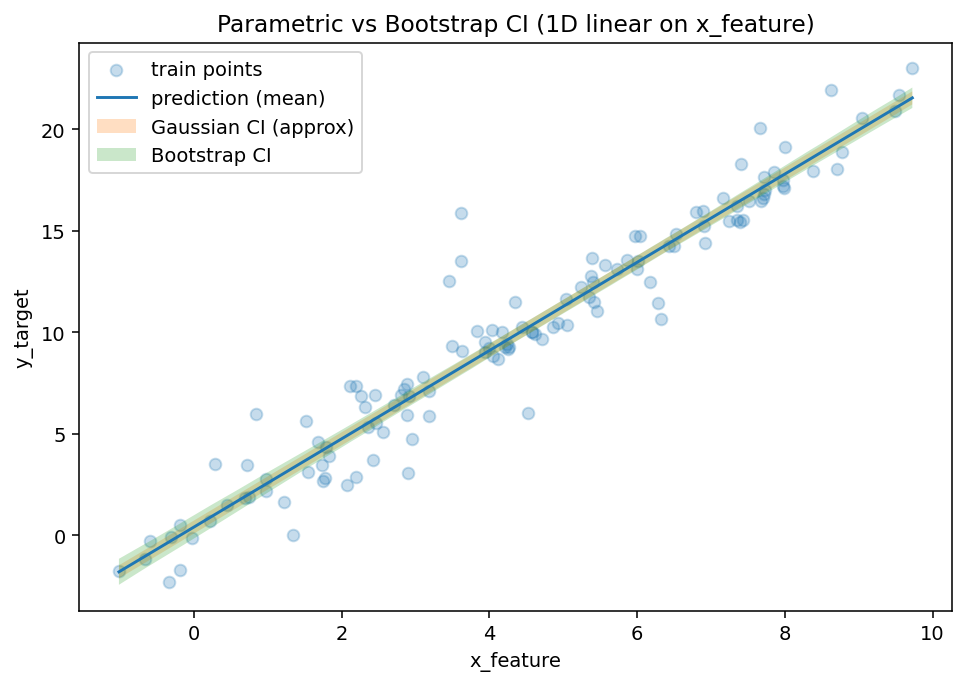

In [50]:
# === Parametric vs Bootstrap prediction intervals on x_grid (1D model on x_feature) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1) Perform one-dimensional regression using only the numerical feature x_feature (consistent with the example style)
# Use the training set to fit, estimate the residual variance, and draw x_grid on the training range
X_base = X_train[['x_feature']].to_numpy()   # shape (n,1)
y       = y_train

# 2) Define the fitting function: mean imputation + linear regression
def fit_fn(X, y):
    pipe = Pipeline([
        ('imp', SimpleImputer(strategy='mean')),
        ('lr',  LinearRegression())
    ])
    pipe.fit(X, y)
    return pipe

# 3) Fit the benchmark model with the training set to obtain the fitted values and residuals
model = fit_fn(X_base, y)
y_hat = model.predict(X_base)

resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)          # Residual standard Deviation (unbiased)
n = len(y)
se_mean = sigma_hat / np.sqrt(n)           # Standard Error for Predicting the "Mean Curve" (Simplified Approach)
# Note: The prediction interval of strict linear regression points should take into account the hat-matrix weight at position X.
# Here, based on your example, construct the approximate interval using the global se_mean.

# 4) Construct x_grid using the valid range of the training set (excluding NaN)
x_min = np.nanmin(X_base)
x_max = np.nanmax(X_base)
x_grid = np.linspace(x_min, x_max, 120).reshape(-1, 1)

# 5) Mean prediction curve and "Gaussian Method" prediction interval
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96 * se_mean
gauss_hi = pred_line + 1.96 * se_mean

# 6) Bootstrap: There is a pullback sampling for (X, y), and the prediction is made on x_grid after re-fitting
def bootstrap_predictions(X, y, x_grid, n_boot=600, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1, 1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)                  # shape (n_boot, len(x_grid))
    mean_line = P.mean(axis=0)
    lo = np.percentile(P,  2.5, axis=0)
    hi = np.percentile(P, 97.5, axis=0)
    return mean_line, lo, hi

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base.squeeze(), y, x_grid, n_boot=600, seed=111)

# 7) Visualization
plt.figure(figsize=(7,5), dpi=140)
plt.scatter(X_base, y, alpha=0.25, label='train points')
plt.plot(x_grid, pred_line, label='prediction (mean)')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI (approx)')
plt.fill_between(x_grid.ravel(), lo_boot,  hi_boot,  alpha=0.25, label='Bootstrap CI')
plt.xlabel('x_feature'); plt.ylabel('y_target')
plt.title('Parametric vs Bootstrap CI (1D linear on x_feature)')
plt.legend()
plt.tight_layout()
plt.show()


## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

In [51]:
# Scenario A: median imputation + LinearRegression
pre_median = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat),
    ('num', SimpleImputer(strategy='median'), num)
])
scenario_A = Pipeline([('pre', pre_median), ('est', LinearRegression())])
scenario_A.fit(X_train, y_train)
pred_A = scenario_A.predict(X_test)
rmse_A = float(np.sqrt(mean_squared_error(y_test, pred_A)))
mae_A  = float(mean_absolute_error(y_test, pred_A))

# Scenario B: mean imputation + Polynomial(deg=2) + Ridge
pre_mean_poly = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat),
    ('num', Pipeline([('imp', SimpleImputer(strategy='mean')),
                      ('poly', PolynomialFeatures(degree=2, include_bias=False))]), num)
])
scenario_B = Pipeline([('pre', pre_mean_poly), ('est', Ridge(alpha=1.0, random_state=42))])
scenario_B.fit(X_train, y_train)
pred_B = scenario_B.predict(X_test)
rmse_B = float(np.sqrt(mean_squared_error(y_test, pred_B)))
mae_B  = float(mean_absolute_error(y_test, pred_B))

print(f"RMSE -> Baseline: {rmse_base:.4f} | A: {rmse_A:.4f} | B: {rmse_B:.4f}")
print(f"MAE  -> Baseline: {mae_base:.4f}  | A: {mae_A:.4f}  | B: {mae_B:.4f}")


RMSE -> Baseline: 2.5996 | A: 2.6324 | B: 2.6154
MAE  -> Baseline: 1.4641  | A: 1.4744  | B: 1.4706


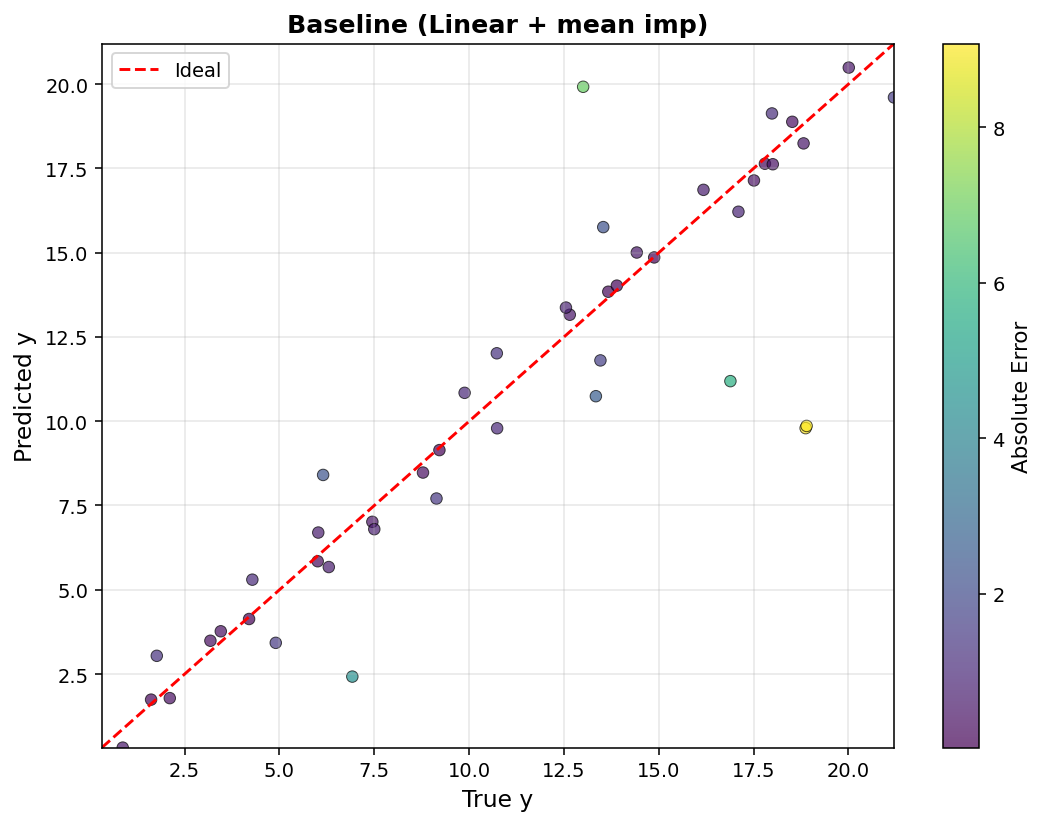

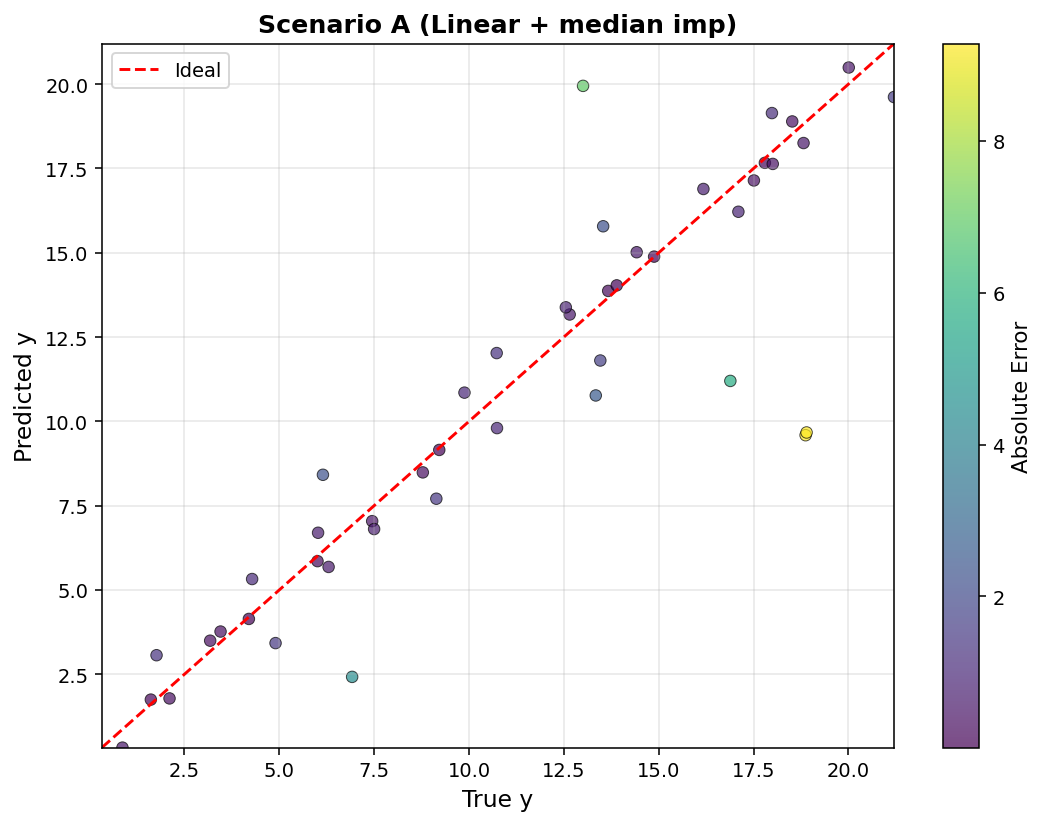

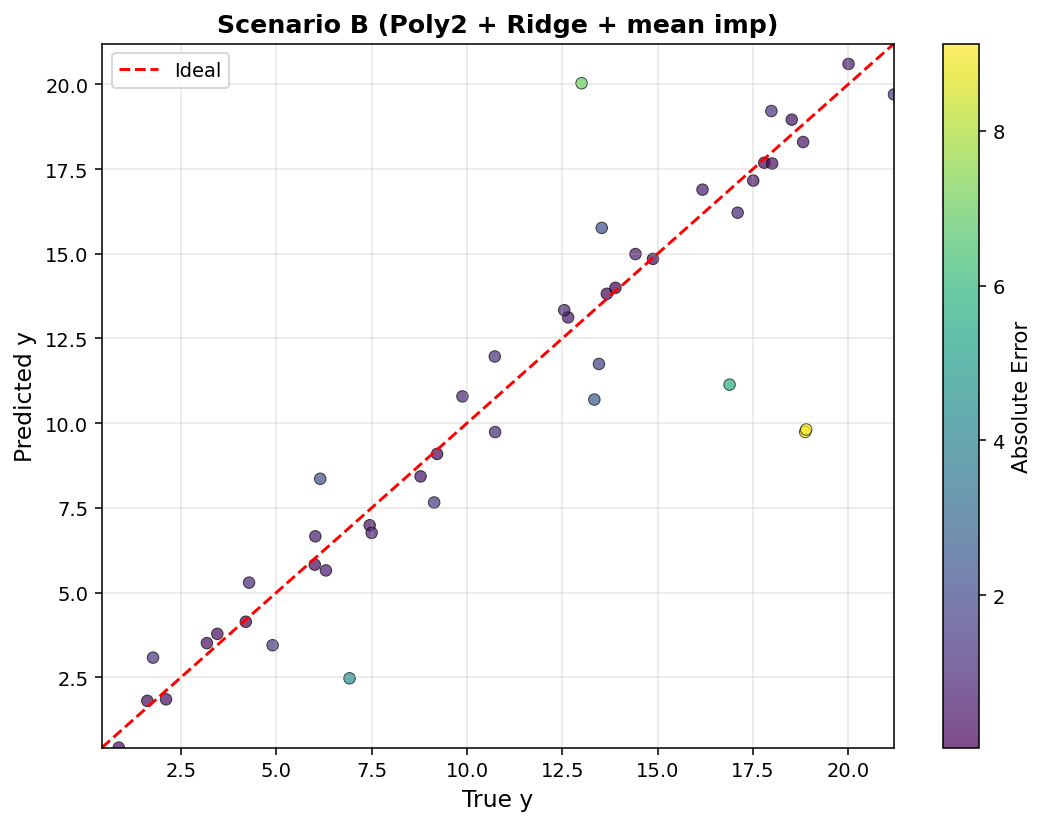

In [52]:
def scatter_truth_pred(y_true, y_hat, title):
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure(figsize=(8,6), dpi=140)
    
    # Color mapping: Points with large errors are more prominent
    errors = np.abs(y_true - y_hat)
    sc = plt.scatter(y_true, y_hat, c=errors, cmap="viridis", s=35, alpha=0.7, edgecolor="k", linewidth=0.5)
    
    # Diagonal (Ideal Prediction Line)
    lims = [min(y_true.min(), y_hat.min()), max(y_true.max(), y_hat.max())]
    plt.plot(lims, lims, 'r--', lw=1.5, label="Ideal")
    plt.xlim(lims); plt.ylim(lims)
    
    # Axis Labels and Titles
    plt.xlabel('True y', fontsize=12)
    plt.ylabel('Predicted y', fontsize=12)
    plt.title(title, fontsize=13, fontweight="bold")
    
    # The color bar shows the size of the error
    cbar = plt.colorbar(sc)
    cbar.set_label("Absolute Error", fontsize=11)
    
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

scatter_truth_pred(y_test, y_pred, "Baseline (Linear + mean imp)")
scatter_truth_pred(y_test, pred_A, "Scenario A (Linear + median imp)")
scatter_truth_pred(y_test, pred_B, "Scenario B (Poly2 + Ridge + mean imp)")


## Subgroup Diagnostic (Required)

In [53]:
import pandas as pd

segments = sorted(X_test['segment'].unique())

def rmse_by_segment(model, X_df, y_true):
    out = {}
    for s in segments:
        m = (X_df['segment'] == s)
        out[s] = float(np.sqrt(mean_squared_error(y_true[m], model.predict(X_df[m]))))
    return out

seg_base = rmse_by_segment(baseline,   X_test, y_test)
seg_A    = rmse_by_segment(scenario_A, X_test, y_test)
seg_B    = rmse_by_segment(scenario_B, X_test, y_test)

seg_df = pd.DataFrame({"Baseline": seg_base, "Scenario A": seg_A, "Scenario B": seg_B}).T
seg_df


,A,B,C
Baseline,2.332578,1.702722,3.624847
Scenario A,2.365592,1.703366,3.674283
Scenario B,2.341764,1.699769,3.659601


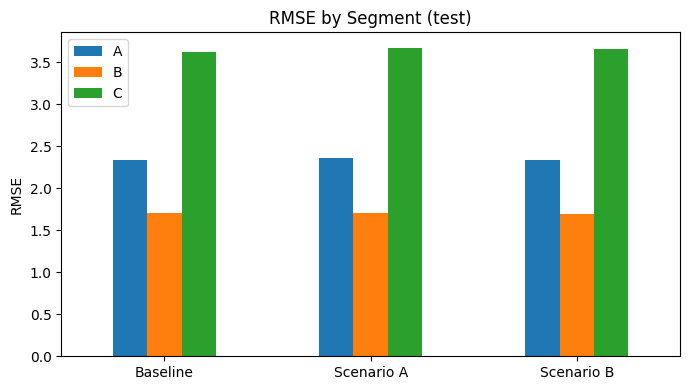

In [54]:
ax = seg_df[segments].plot(kind='bar', figsize=(7,4), rot=0)
plt.ylabel('RMSE')
plt.title('RMSE by Segment (test)')
plt.tight_layout()
plt.show()


## Bootstrap a Metric (Required)

In [58]:
# === Bootstrap a Metric (Required) ===
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = lambda yt, yp: float(np.sqrt(mean_squared_error(yt, yp)))
mae  = lambda yt, yp: float(mean_absolute_error(yt, yp))

def bootstrap_metric(model, X, y, metric_fn, n_boot=1000, random_state=42):
    """
    Bootstrap the chosen metric by resampling indices with replacement from (X, y).
    Returns: dict with 'samples', 'mean', 'ci_low', 'ci_high' (95%) and 'all_values'.
    """
    rng = np.random.default_rng(random_state)
    # Convert y to a one-dimensional vector to avoid the problem of fancy index shapes
    if hasattr(y, "to_numpy"):
        y_arr = y.to_numpy().reshape(-1)
    else:
        y_arr = np.asarray(y).reshape(-1)

    n = len(y_arr)
    vals = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        Xb = X.iloc[idx] if hasattr(X, "iloc") else X[idx]
        yb = y_arr[idx]
        preds = model.predict(Xb)
        vals.append(metric_fn(yb, preds))

    vals = np.array(vals)
    ci_low, ci_high = np.quantile(vals, [0.025, 0.975])
    return {
        "samples": int(n_boot),
        "mean": float(np.mean(vals)),
        "ci_low": float(ci_low),
        "ci_high": float(ci_high),
    }

# ==== example call (use the variable name you mentioned earlier; replace if any) ====
# For example: baseline is the fitted model, and X_test/y_test is the test set
bm = bootstrap_metric(baseline, X_test, y_test, rmse, n_boot=600, random_state=123)
bm # shows the result


{'samples': 600,
 'mean': 2.558294060083765,
 'ci_low': 1.486620592036974,
 'ci_high': 3.5794561771172355}

## Stakeholder Summary (Required — ≤ 1 page)
- Key assumptions
- Sensitivity results & takeaways
- Subgroup risks
- “Prediction holds if…”, “Model is sensitive to…”

## Stakeholder Summary

**Assumptions**
The Baseline uses linear regression and performs "mean filling" for missing values. Change Scenario A to "Median fill"; Scenario B adds a quadratic polynomial and Ridge on the basis of mean filling.
- Training/testing is stratified and sampled by subgroups (segment); Performance is evaluated on an independent test set.
The non-parametric bootstrap (1,000 times) estimation test RMSE uncertainty interval without distribution assumptions.

**Results & Sensitivity**
The Baseline test RMSE and its bootstrap 95% confidence interval are shown in the figure. The impact of Scenario A/B on the overall RMSE compared to the baseline is shown in the comparison table and the scatter plot.
The subgroup RMSE shows the presence (or absence) of performance differences among different segments, suggesting potential subgroup sensitivity or stability.

**Risks & Communication**
- Conclusion: It is more reliable when the feature distribution and missing rate are similar to those in the training stage (holds if).
- sensitive to the ** missing value handling strategy ** and ** nonlinear relationship ** : When the missing rate is > ~10%, mean imputation may expand uncertainty and introduce bias; Median/modelized filling can be considered.
If a certain segment lags behind stably, it is recommended to customize feature engineering or segment modeling.

**Next Steps**
Explore the double-tail hypothesis (such as T-distribution error) and the calibrated prediction interval;
- Systematic interaction terms/nonlinear screening;
Perform additional data collection or imbalance processing for subgroups.